In [43]:
# standard imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time as time

# 3rd party packages
import qiskit as qk
import networkx as nx
import tenpy as tp

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit
import circuits.basic_circuits as circuits



## HoloPy demo: spin-chain

XXZ: $$H_\text{XXZ}=\sum_{i=1}^{L-1} \sigma^x_{i}\sigma^x_{i+1}+\sigma^y_{i}\sigma^y_{i+1} + \Delta \sigma^z_i\sigma^z_{i+1}$$

Ising: $$H_\text{TFIM}=\sum_i -J\sigma^x_i\sigma^x_{i+1}-h\sigma^x_{i}$$

In [ ]:
# ansatz parameters
nb = 2 # number of bond-qubits 
L = 1 # number of unit cells
l_uc = 1 # number of sites in unit cell

In [3]:
## Setup IsoMPS ##
# initialize registers
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Initialize parameterized circuits
# bond-prep circuit (sets left-boundary vector of MPS)
bond_prep_circ = QKParamCircuit(qk.QuantumCircuit(breg),[])
pcircs = [bond_prep_circ]

# circuits that generate tensors
param_names= [] # list of circuit parameters
for j in range(l_uc):
    circ_tmp,params_tmp = circuits.star_circ(preg,
                                             breg,
                                             label='[c{}]'.format(j),
                                             circ_type='xxz') 
    pcircs+=[circ_tmp]
    param_names+=params_tmp

# setup circuit-generated isoMPS
psi = IsoMPS(preg,breg,pcircs,L=L)

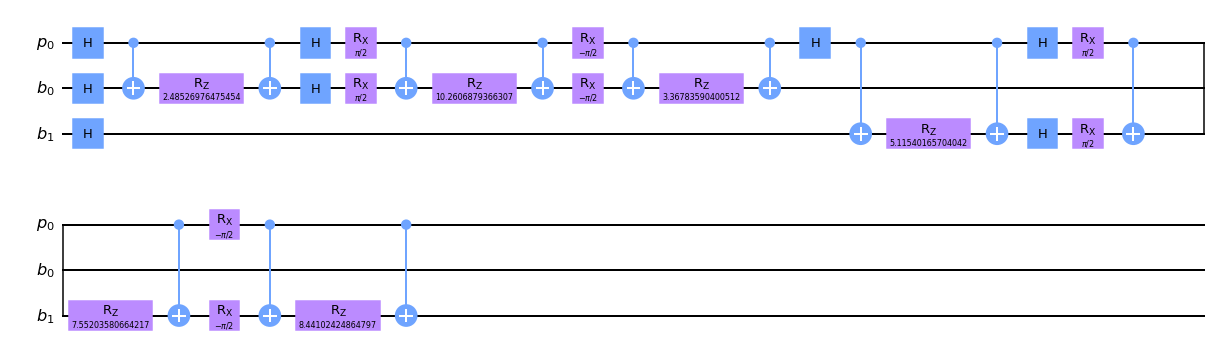

In [4]:
## Example (resolve parameters => random values and print circuit)
# pick some random parameter values
param_vals = [4*np.pi*np.random.rand() for j in range(len(param_names))]
param_dict = dict(zip(param_names,param_vals))
psi.construct_circuit(param_dict,include_measurements=False)
psi.circ.draw('mpl')

## 1. Compute energy by exporting to tenpy

In [58]:
## Functions to create tenpy models
def ising_impo(J, h):
    site = tp.networks.site.SpinHalfSite(conserve=None)
    #Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
    #Sx = Sp + Sm
    Id, Sx, Sz = site.Id, site.Sigmax, site.Sigmaz
    W = [[Id,Sx,-h*Sz], 
         [None,None,-J*Sx], 
         [None,None,Id]]
    H = tp.networks.mpo.MPO.from_grids([site], [W], bc='infinite', IdL=0, IdR=-1)
    return H

def xxz_impo(Delta):
    """
    Doesn't work! (leg-charge error?)
    """
    site = tp.networks.site.SpinHalfSite(conserve=None)
    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, site.Sigmaz
    Sx = Sp + Sm
    W = [[Id,Sp,Sm,Sz], 
         [None,None,None,1/2*Sm],
         [None,None,None,1/2*Sp],
         [None,None,None,Delta*Sz],
         [None,None,None,Id]]
    H = tp.networks.mpo.MPO.from_grids([site], [W], bc='infinite', IdL=0, IdR=-1)
    return H

# energy calculator
def energy_tp(param_vals,*args):
    """
    function to calculate energy using MPO/MPS contraction in tenpy
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi=args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    param_dict = dict(zip(param_names,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    psi_tp = psi.to_tenpy(param_dict,L=np.inf)
    
    # compute energy
    E = (H_mpo.expectation_value(psi_tp)).real
    return E

In [69]:
H_mpo = ising_impo(J=1,h=1) # Hamiltonian as tenpy MPO
x0 = 0.03*np.random.randn(len(param_names)) # starting point for parameters

t0 = time.time()
opt_result = minimize(energy_tp, # function to minimize
                      x0, # starting point for parameters 
                      args=(psi,H_mpo), # must take form (isoMPS,tenpy MPO)
                      method='BFGS'
                     )
tf = time.time()
# set parameters to previously optimized values
opt_vals = opt_result.x
opt_params = dict(zip(param_names,opt_vals))

print('Optimization done, elapsed time: {}'.format(tf-t0))
print('Optimized energy = {}'.format(opt_result.fun))

Optimization done, elapsed time: 41.69171500205994
Optimized energy = -1.2712615336752897


## 2. Qiskit simulations
Now, compute the energy for the optimized parameter values in qiskit

In [70]:
L=10 # length of chain to simulate
measurement_strings = ['z'*L,'x'*L] # list of Pauli strings to measure
shots = 100

In [ ]:
# loop through measurement strings, and create list of jobs to run
psis=[]
circs = []
results = []
for m in measurement_strings:
    psi_curr = IsoMPS(preg,breg,pcircs,bases=[m],L=L)
    circ_curr = psi_mps.construct_circuit(opt_params)